## **Library**: 
Load the libraries needed for the project.
Main library use are:
- **Machine learning** : sklearn, shap
- **Data manipulation** : numpy, pandas
- **Plot**: seaborn, matplotlib
- **Python** tools: itertools and pickle

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import pickle as pkl
import seaborn as sns
import pickle as pkl
from sklearn import tree as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold


/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Functions**: 


In [2]:
def run_on_splits(func):
    def _run_loop(*args, **kwargs):
        for x,y,nsplit in zip([X_train, X_val, X_test],
                              [y_train, y_val, y_test],
                              ['train', 'val', 'test']):
            func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
    return _run_loop

In [3]:
@run_on_splits
def evaluate(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    predict_y = model.predict(X)
    precision = precision_score(y, predict_y, average='binary')
    recall = recall_score(y, predict_y, average='binary')
    precision_more = precision_score(y, predict_y, average=None,labels= [0,1])
    f1 = f1_score(y, predict_y)
    accuracy = accuracy_score(y, predict_y)
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:, 1]) if hasattr(model, "predict_proba") else None
    conf_matrix = confusion_matrix(y, predict_y)

    performances.append({'model': model_name,
                         'split': nsplit,
                         'recall': recall,
                         'f1': f1,
                         'precision': precision,
                        'precision_more': precision_more,
                         'accuracy': accuracy,
                         'roc_auc': roc_auc,
                         'confusion_matrix': conf_matrix.tolist()})



In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
@run_on_splits
def evaluate_2(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    predict_y = model.predict(X)
    precision = precision_score(y, predict_y, average='macro')
    recall = recall_score(y, predict_y, average='macro')
    f1 = f1_score(y, predict_y, average='macro')
    accuracy = accuracy_score(y, predict_y)

    performances.append({
        'model': model_name,
        'split': nsplit,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    })

# Example usage:
# evaluate_2(some_model, X_test, y_test, 'test_split', 'model_name')


In [37]:
def fit_and_evaluate_models(X_train, y_train, subset_name):
    ''' 
    Fits and evaluates models on a given subset of data 
    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): Training labels
        subset_name (str): Name of the subset
    '''

    def fit_and_evaluate(model, param_grid, model_name):
        if len(param_grid) * min([len(v) for v in param_grid.values()]) <= 20:
            search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='precision', cv=5, n_jobs=-1)
        else:
            search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='precision', n_iter=20, cv=5, n_jobs=-1)
        reg = search.fit(X_train, y_train)
        with open(f'/Users/sylvainestebe/Code/data_child/models/Q1_{model_name}_{subset_name}.pkl', 'wb') as file:
            pkl.dump(reg, file)  # save the model
        evaluate(model=search.best_estimator_, model_name=f'{model_name}_{subset_name}')

    # Dummy Classifier
    dummy_clf = DummyClassifier(strategy="constant", constant=1)
    dummy_clf.fit(X_train, y_train)
    evaluate(model=dummy_clf,model_name=f'dummy_{subset_name}')

    # Logistic Regression
    logistic_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Adding scaler
        ('logistic', LogisticRegression(random_state=42, max_iter=5000))
    ])
    fit_and_evaluate(
        logistic_pipeline, 
        {'logistic__C': [0.01, 0.1, 1, 10, 100]}, 
        'logistic'
    )

    # SVM
    fit_and_evaluate(
        svm.SVC(), 
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}, 
        'svm'
    )

    # Decision Tree
    fit_and_evaluate(
        tree.DecisionTreeClassifier(random_state=42), 
        {'max_depth': [2, 5, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}, 
        'tree'
    )

    # Random Forest
    fit_and_evaluate(
        RandomForestClassifier(random_state=42), 
        {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]        }, 
        'randomforest'
    )

    # XGBoost
    fit_and_evaluate(
        XGBClassifier(random_state=42), 
        {
            'n_estimators': [10, 50, 100, 200,300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 10, 100],
        }, 
        'xgboost'
    )



    # Define the neural network pipeline
    nn_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(max_iter=1100, random_state=42))
    ])

    # Call fit_and_evaluate with the correctly prefixed parameters
    fit_and_evaluate(
        nn_pipeline, 
        {
            'mlp__hidden_layer_sizes': [(50, 50), (100,), (100, 50)],
            'mlp__activation': ['tanh', 'relu'],
            'mlp__solver': ['adam', 'sgd'],
            'mlp__alpha': [0.0001, 0.001, 0.01],
            'mlp__learning_rate': ['constant', 'adaptive'],
            'mlp__max_iter': [200, 400, 600]        
        }, 
        'neural_network'
    )

        # HistGradientBoostingClassifier
    fit_and_evaluate(
        HistGradientBoostingClassifier(random_state=42),
        {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_iter': [100, 200,300],
            'max_depth': [3, 6, 9],
            'l2_regularization': [0, 0.1, 1, 10]

        },
        'histgradientboosting'
    )


In [36]:
def fit_and_evaluate_models_2(X_train, y_train, subset_name):
    ''' 
    Fits and evaluates models on a given subset of data 
    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): Training labels
        subset_name (str): Name of the subset
    '''

    def fit_and_evaluate_2(model, param_grid, model_name):
        if len(param_grid) * min([len(v) for v in param_grid.values()]) <= 20:
            search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
        else:
            search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='f1_macro', n_iter=20, cv=5, n_jobs=-1)
        reg = search.fit(X_train, y_train)
        with open(f'/Users/sylvainestebe/Code/data_child/models/Q2_{model_name}_{subset_name}.pkl', 'wb') as file:
            pkl.dump(reg, file)  # save the model
        evaluate_2(model=search.best_estimator_, model_name=f'{model_name}_{subset_name}')

    # Dummy Classifier
    dummy_clf = DummyClassifier(strategy="constant", constant=1)
    dummy_clf.fit(X_train, y_train)
    evaluate_2(model=dummy_clf, model_name=f'dummy_{subset_name}')

    # Logistic Regression
    logistic_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Adding scaler
        ('logistic', LogisticRegression(random_state=42, max_iter=5000, solver='liblinear'))
    ])
    fit_and_evaluate_2(
        logistic_pipeline, 
        {'logistic__C': [0.01, 0.1, 1, 10, 100], 'logistic__penalty': ['l1', 'l2']}, 
        'logistic'
    )

    # SVM
    fit_and_evaluate_2(
        svm.SVC(random_state=42), 
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}, 
        'svm'
    )

    # Decision Tree
    fit_and_evaluate_2(
        tree.DecisionTreeClassifier(random_state=42), 
        {'max_depth': [2, 5, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}, 
        'tree'
    )

    # Random Forest
    fit_and_evaluate_2(
        RandomForestClassifier(random_state=42), 
        {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]        
        }, 
        'randomforest'
    )

    # XGBoost
    fit_and_evaluate_2(
        XGBClassifier(random_state=42), 
        {
            'n_estimators': [10, 50, 100, 200,300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 10, 100],
        }, 
        'xgboost'
    )

    # Define the neural network pipeline
    nn_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(max_iter=1100, random_state=42))
    ])

    # Call fit_and_evaluate with the correctly prefixed parameters
    fit_and_evaluate_2(
        nn_pipeline, 
        {
            'mlp__hidden_layer_sizes': [(50, 50), (100,), (100, 50)],
            'mlp__activation': ['tanh', 'relu'],
            'mlp__solver': ['adam', 'sgd'],
            'mlp__alpha': [0.0001, 0.001, 0.01],
            'mlp__learning_rate': ['constant', 'adaptive'],
            'mlp__max_iter': [200, 400, 600]        
        }, 
        'neural_network'
    )

        # HistGradientBoostingClassifier
    fit_and_evaluate_2(
        HistGradientBoostingClassifier(random_state=42),
        {
            'learning_rate': [0.01, 0.1, 0.2],
            'max_iter': [100, 200,300],
            'max_depth': [3, 6, 9],
            'l2_regularization': [0, 0.1, 1, 10]

        },
        'histgradientboosting'
    )


# Data

In [7]:
# Loading dataset
data_child = pd.read_csv("/Users/sylvainestebe/Code/data_child/data/dataset.csv")

/var/folders/td/5r8mr8t14cn_c4w5c8ty48lw0000gn/T/ipykernel_34177/2786542852.py:2: DtypeWarning: Columns (96,111) have mixed types. Specify dtype option on import or set low_memory=False.
  data_child = pd.read_csv("/Users/sylvainestebe/Code/data_child/data/dataset.csv")


In [8]:
# Create a subset of the dataset with variables of interest
data = {
# Demographic data
        'Age': data_child.Age,
        'Region': data_child.Dep, # Encode region data as a categorical feature
        'Postcode': data_child.CodePostalBaseline, # Encode postcode data as a categorical feature
        'SingleMom' : data_child.SingleMum,
        'Couple' : data_child.Couple,
        'Relationship_type' : data_child.Relationship,
        'Educ' : data_child.Educ,
        'Income': data_child.IncomeBaseline,
        'Job': data_child.Occupation,
        'Job_partner': data_child.Occupation2,
        'Job_After': data_child.AfterBirthOccupation,


# Knowledge data ComputerYN
        'NumberKnown' :data_child.KnownNbTypeECS,
        'Computer_access' :data_child.ComputerYN,

# Trust data De manière générale, j’ai confiance dans les personnes suivantes pour prendre soin de mon enfant. (TrustFam	TrustFriend	TrustAssMat	TrustCreche)
        'Trust_creche' :data_child.TrustCreche1or0,

# Easy to access data
        'Access' :data_child.AccessEasyBaseline,
# Psy data
        'Happy': data_child.PsyWellBeingHappy,
        'Quite': data_child.PsyWellBeingQuite,
        'Vigou': data_child.PsyWellBeingVigou,
        'Fresh': data_child.PsyWellBeingFresh,
        'Stimu': data_child.PsyWellBeingStimu,

# Values data (VALUES Voici une série de valeurs. Parmi ces valeurs, c’est quoi les 2 valeurs qui vous semblent les plus importantes à acquérir pour un enfant avant de rentrer à la maternelle ?)
        'ValGenerosity': data_child.ValGenerosity,
        'ValIndependence': data_child.ValIndependence,
        'ValSocialisation': data_child.ValSocialisation,
        'ValObedience': data_child.ValObedience,
        'ValEducation': data_child.ValEducation,
        'ValDK': data_child.ValDK,
        'ValImagination': data_child.ValImagination,

# DeprivClothes	DeprivFood	DeprivBills	DeprivHolidays	DeprivHousing DEPRIVATION Là c'est une partie sur votre bien être économique. Au cours des derniers mois, est-ce que vous avez eu des difficultés économiques pour...
# Economic difficulties
        'DeprivFood': data_child.DeprivFood,
        'DeprivBills': data_child.DeprivBills,
        'DeprivHolidays': data_child.DeprivHolidays,
        'DeprivHousing': data_child.DeprivHousing,

# Norms data
        'TradNorm': data_child.TradNormsScore,
# Output
        'Intention' : data_child.Intention, # Intention to put a baby in a structure
        'Applied' : data_child.ECSApp, # Applied for a structure
        'Use' : data_child.ECSUseYes # Use a structure (hence accepted)
}

df = pd.DataFrame(data)

## **Preprocessing**: 
Check NA values, Encode Data..

In [9]:
print(df.isna().sum())


Age                   0
Region                0
Postcode              0
SingleMom             0
Couple                0
Relationship_type     0
Educ                  0
Income               97
Job                   0
Job_partner           0
Job_After             0
NumberKnown           0
Computer_access       0
Trust_creche          0
Access                0
Happy                 0
Quite                 0
Vigou                 0
Fresh                 0
Stimu                 0
ValGenerosity         0
ValIndependence       0
ValSocialisation      0
ValObedience          0
ValEducation          0
ValDK                 0
ValImagination        0
DeprivFood            1
DeprivBills          15
DeprivHolidays       19
DeprivHousing         8
TradNorm              0
Intention             0
Applied               0
Use                   0
dtype: int64


In [10]:
# Replace na values with mean

df.Income = df.Income.fillna(str(df.Income.mean))
df.DeprivBills = df.DeprivBills.fillna(str(df.DeprivBills.mean))
df.DeprivHolidays = df.DeprivHolidays.fillna(str(df.DeprivBills.mean))
df.DeprivFood = df.DeprivFood.fillna(str(df.DeprivBills.mean))

In [11]:
type(df.Income[1])

str

In [12]:
print(df.isna().sum())
# 5 NA what to do with?

Age                  0
Region               0
Postcode             0
SingleMom            0
Couple               0
Relationship_type    0
Educ                 0
Income               0
Job                  0
Job_partner          0
Job_After            0
NumberKnown          0
Computer_access      0
Trust_creche         0
Access               0
Happy                0
Quite                0
Vigou                0
Fresh                0
Stimu                0
ValGenerosity        0
ValIndependence      0
ValSocialisation     0
ValObedience         0
ValEducation         0
ValDK                0
ValImagination       0
DeprivFood           0
DeprivBills          0
DeprivHolidays       0
DeprivHousing        8
TradNorm             0
Intention            0
Applied              0
Use                  0
dtype: int64


In [13]:
# check in their are inconsistency in the dataset 
df.dtypes
# there are some objects data (string) and booleen data. I would like to convert everything in number.

Age                   int64
Region                int64
Postcode              int64
SingleMom              bool
Couple                 bool
Relationship_type    object
Educ                 object
Income               object
Job                  object
Job_partner          object
Job_After            object
NumberKnown           int64
Computer_access      object
Trust_creche          int64
Access               object
Happy                object
Quite                object
Vigou                object
Fresh                object
Stimu                object
ValGenerosity         int64
ValIndependence       int64
ValSocialisation      int64
ValObedience          int64
ValEducation          int64
ValDK                 int64
ValImagination        int64
DeprivFood           object
DeprivBills          object
DeprivHolidays       object
DeprivHousing        object
TradNorm              int64
Intention            object
Applied               int64
Use                   int64
dtype: object

In [14]:
label_encoder = LabelEncoder()
# Transformer les codes postaux en labels numériques
df['Job'] = label_encoder.fit_transform(df['Job'])
df['Job_partner'] = label_encoder.fit_transform(df['Job_partner'])
df['Job_After'] = label_encoder.fit_transform(df['Job_After'])
df['Computer_access'] = label_encoder.fit_transform(df['Computer_access'])

df['DeprivFood'] = label_encoder.fit_transform(df['DeprivFood'])
df['DeprivBills'] = label_encoder.fit_transform(df['DeprivBills'])
df['DeprivHolidays'] = label_encoder.fit_transform(df['DeprivHolidays'])
df['DeprivHousing'] = label_encoder.fit_transform(df['DeprivHousing'])


# Transformer les codes postaux en labels numériques
df['Postcode'] = label_encoder.fit_transform(df['Postcode'])
# Transformer les régions en labels numériques
df['Region'] = label_encoder.fit_transform(df['Region'])
# Transform Education data into number
df['Educ'] = label_encoder.fit_transform(df['Educ'])
# Transform Couple data into number
df['Couple'] = label_encoder.fit_transform(df['Couple'])
# Transform Couple data into number
df['Relationship_type'] = label_encoder.fit_transform(df['Relationship_type'])
# Transform Couple data into number
df['Access'] = label_encoder.fit_transform(df['Access'])
# Transform Psy data into number
df['Happy'] = label_encoder.fit_transform(df['Happy'])
df['Quite'] = label_encoder.fit_transform(df['Quite'])
df['Vigou'] = label_encoder.fit_transform(df['Vigou'])
df['Fresh'] = label_encoder.fit_transform(df['Fresh'])
df['Stimu'] = label_encoder.fit_transform(df['Stimu'])
# Transform income data into number
df['Income'] = label_encoder.fit_transform(df['Income'])
# Transform intention data into number
df['Intention'] = label_encoder.fit_transform(df['Intention'])
# Transform single mom data into number
df['SingleMom'] = label_encoder.fit_transform(df['SingleMom'])


# Fusionner en une colonne multi-classes
def combine_classes(row):
    if row['Applied'] == 0 and row['Use'] == 0:
        return 0
    elif row['Applied'] == 1 and row['Use'] == 0:
        return 1
    elif row['Applied'] == 0 and row['Use'] == 1:
        return 2
    elif row['Applied'] == 1 and row['Use'] == 1:
        return 3

df['Combined'] = df.apply(combine_classes, axis=1)
df['Combined'] = label_encoder.fit_transform(df['Combined'])

df['Total_Deprivation'] = df[['DeprivFood', 'DeprivBills', 'DeprivHolidays', 'DeprivHousing']].sum(axis=1)
df['Total_Deprivation'] = df[['ValGenerosity', 'ValIndependence', 'ValSocialisation', 'ValObedience','ValEducation','ValDK','ValImagination' ]].sum(axis=1)
df['Total_Psy'] = df[['Happy', 'Quite', 'Vigou', 'ValObedience','Fresh','Stimu' ]].sum(axis=1)
scaler = StandardScaler()
df[['Age', 'Income']] = scaler.fit_transform(df[['Age', 'Income']])


In [15]:
df.isna().sum()

Age                  0
Region               0
Postcode             0
SingleMom            0
Couple               0
Relationship_type    0
Educ                 0
Income               0
Job                  0
Job_partner          0
Job_After            0
NumberKnown          0
Computer_access      0
Trust_creche         0
Access               0
Happy                0
Quite                0
Vigou                0
Fresh                0
Stimu                0
ValGenerosity        0
ValIndependence      0
ValSocialisation     0
ValObedience         0
ValEducation         0
ValDK                0
ValImagination       0
DeprivFood           0
DeprivBills          0
DeprivHolidays       0
DeprivHousing        0
TradNorm             0
Intention            0
Applied              0
Use                  0
Combined             0
Total_Deprivation    0
Total_Psy            0
dtype: int64

In [16]:
# Check if there are missing values
print(df.isna().sum())

# Stock name of columns
columns = df.columns
print(columns)
df

Age                  0
Region               0
Postcode             0
SingleMom            0
Couple               0
Relationship_type    0
Educ                 0
Income               0
Job                  0
Job_partner          0
Job_After            0
NumberKnown          0
Computer_access      0
Trust_creche         0
Access               0
Happy                0
Quite                0
Vigou                0
Fresh                0
Stimu                0
ValGenerosity        0
ValIndependence      0
ValSocialisation     0
ValObedience         0
ValEducation         0
ValDK                0
ValImagination       0
DeprivFood           0
DeprivBills          0
DeprivHolidays       0
DeprivHousing        0
TradNorm             0
Intention            0
Applied              0
Use                  0
Combined             0
Total_Deprivation    0
Total_Psy            0
dtype: int64
Index(['Age', 'Region', 'Postcode', 'SingleMom', 'Couple', 'Relationship_type',
       'Educ', 'Income', 'Job', '

,Age,Region,Postcode,SingleMom,Couple,Relationship_type,Educ,Income,Job,Job_partner,...,DeprivBills,DeprivHolidays,DeprivHousing,TradNorm,Intention,Applied,Use,Combined,Total_Deprivation,Total_Psy
0,-0.419513,2,99,0,1,0,1,-0.714911,4,2,...,3,3,2,0,1,1,1,2,2,18
1,0.647294,2,101,0,1,0,0,-0.714911,4,5,...,3,4,2,0,1,1,0,1,2,14
2,-0.597314,1,55,0,1,0,1,0.336500,4,5,...,3,3,2,0,1,1,1,2,2,17
3,1.891902,0,18,0,1,1,1,0.336500,4,5,...,3,3,2,0,1,1,1,2,2,17
4,1.358499,2,88,0,1,0,1,0.686970,4,5,...,3,3,2,0,1,1,1,2,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,-0.419513,0,10,0,1,0,1,-0.013971,4,5,...,4,4,0,0,1,1,1,2,2,10
1451,0.647294,1,34,0,1,0,1,-1.065382,2,5,...,4,1,2,50,0,0,0,0,2,13
1452,0.291692,1,40,0,1,0,0,1.387911,4,3,...,1,1,3,50,1,1,0,1,2,11
1453,-0.419513,0,17,0,1,0,1,2.088852,1,5,...,3,3,0,0,1,1,0,1,2,14


## **Exploratory**: 
I want to have a simpler model. Cause a simpler model is more interpretable and is less subject to overfitting and shorter in training time if I want to use more data in one country.
Where I try to find if there are outlier and if the dataset is representative  

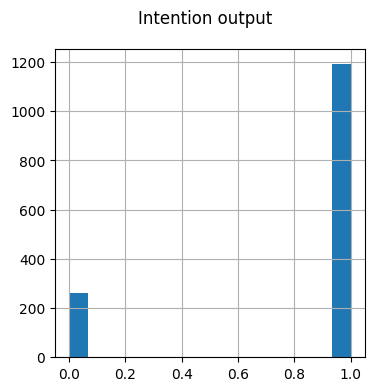

In [17]:
# Visualise the output
df["Intention"].hist(figsize=(4, 4), bins=15)
plt.suptitle('Intention output')
plt.show()

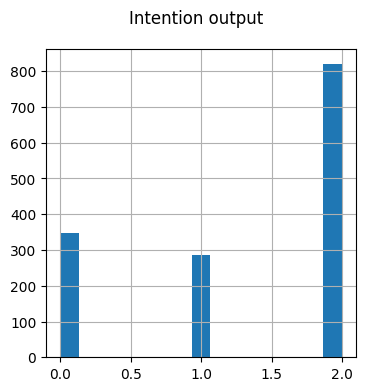

In [18]:
# Visualise the output
df["Combined"].hist(figsize=(4, 4), bins=15)
plt.suptitle('Intention output')
plt.show()

In [19]:
# Visualize the distribution of numerical features
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

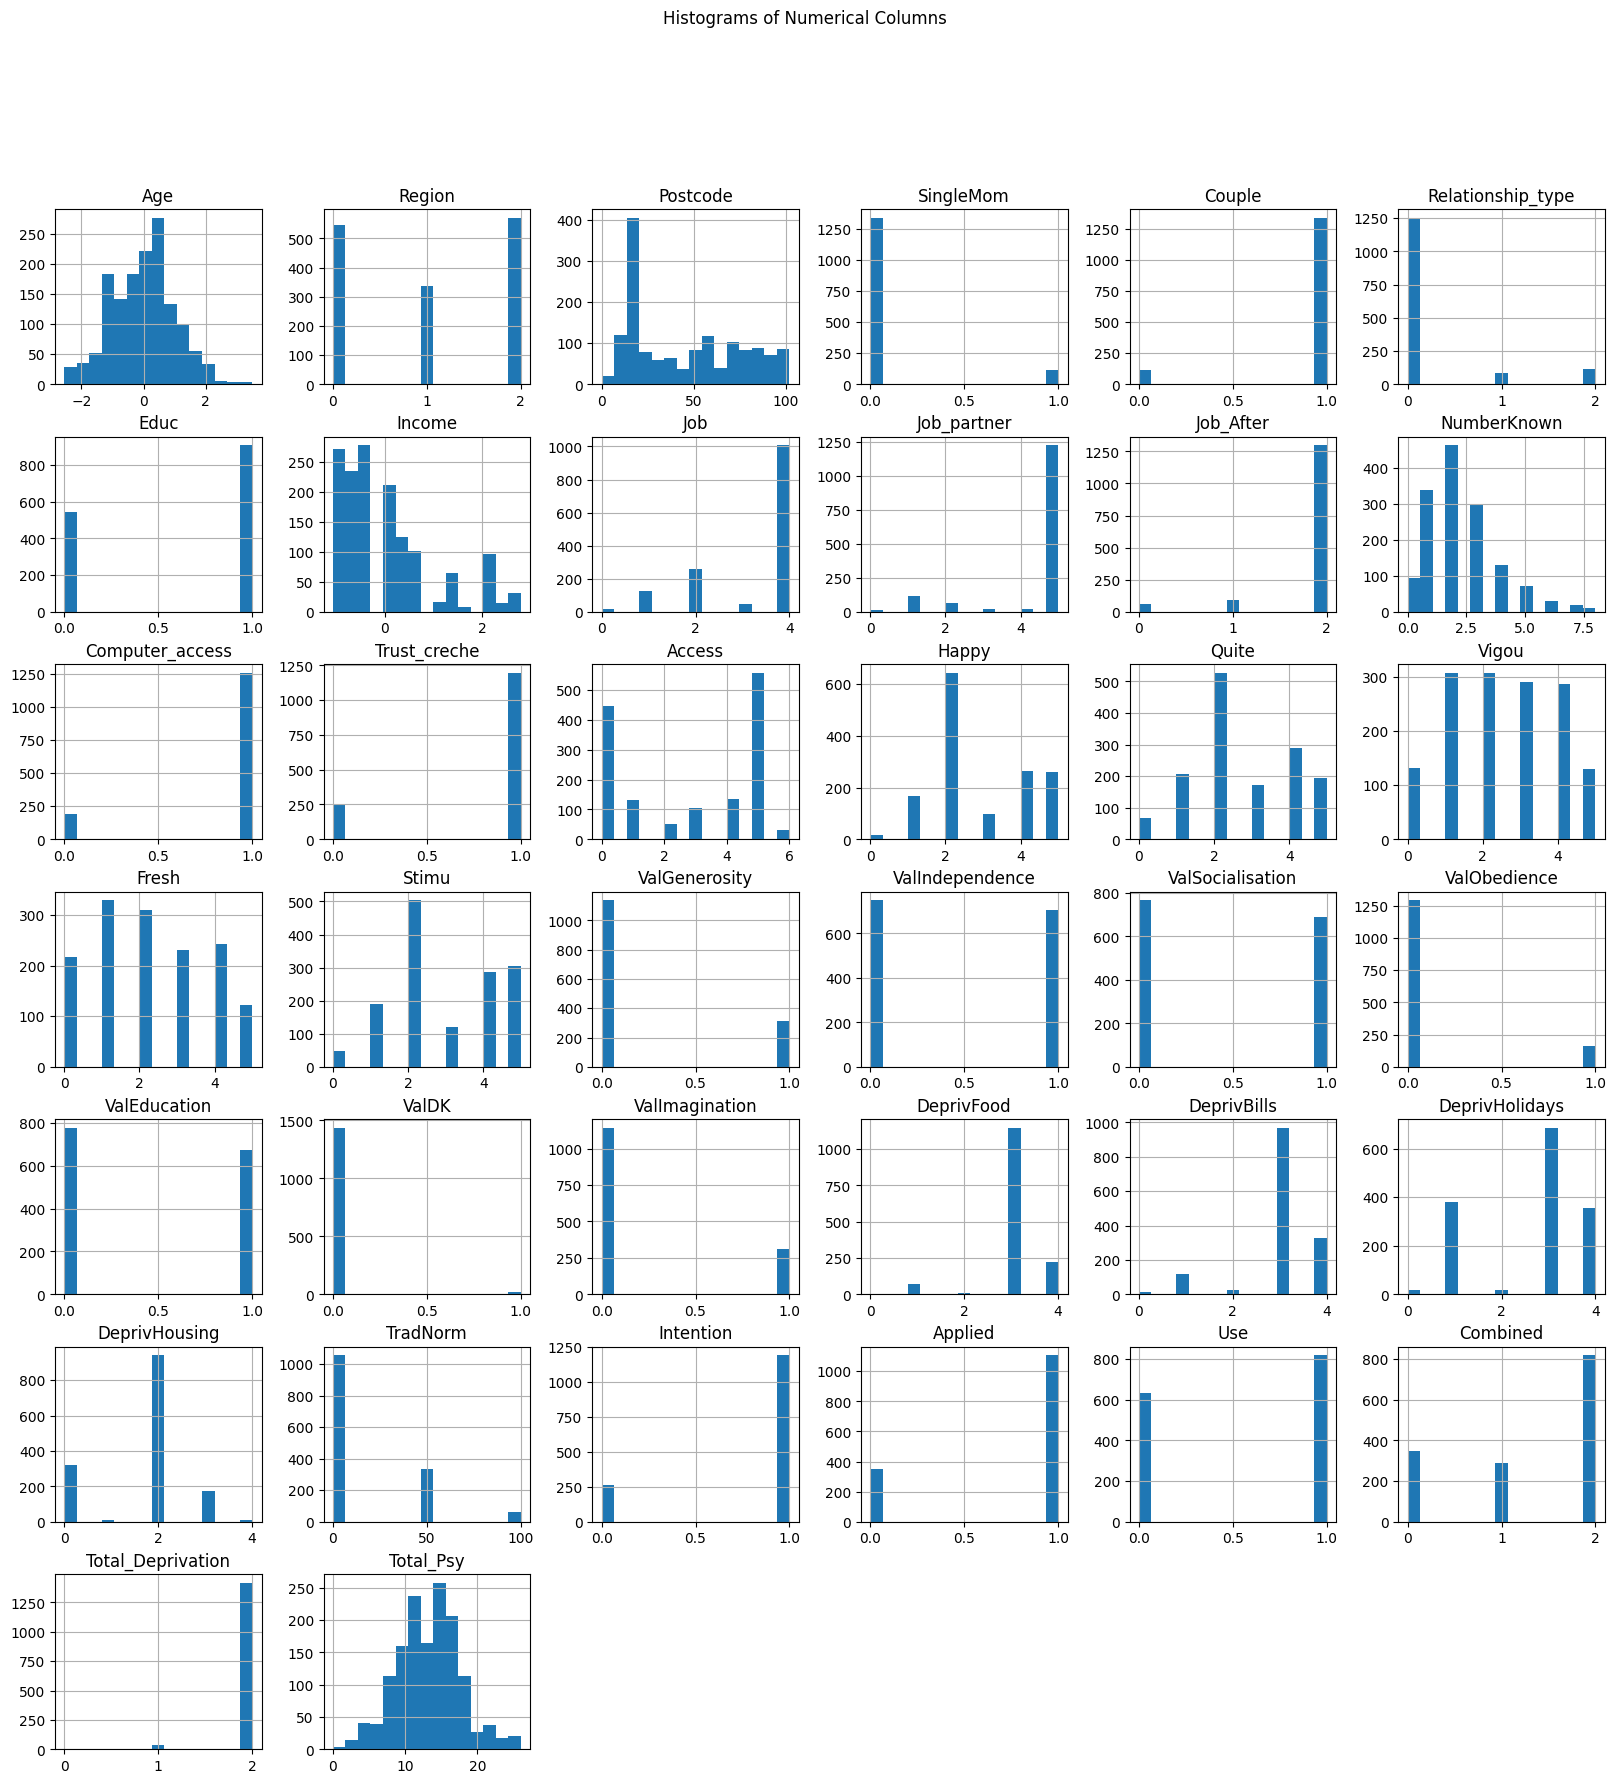

In [20]:
# Plot histograms for numerical columns
df[numerical_columns].hist(figsize=(20, 20), bins=15)
plt.suptitle('Histograms of Numerical Columns')
plt.show()

In [21]:
# Assuming df is your DataFrame
# Log transformation (add 1 to avoid log(0) issue)
#log_transform_columns = [
#    'Income', 'NumberKnown', 'Trust_creche', 'Access', 'Happy', 'Quite', 'Vigou',
#    'Fresh', 'Stimu', 'ValGenerosity', 'ValIndependence', 'ValSocialisation',
#    'ValImagination', 'Total_Psy'
#]

# Handle NaN values by filling with a small positive number (e.g., 1e-6)
#df[log_transform_columns] = df[log_transform_columns].fillna(1e-6)

# Apply log transformation (add 1 to avoid log(0) issue)
#for col in log_transform_columns:
#    df[col] = np.log1p(df[col])

#df.isna().sum()

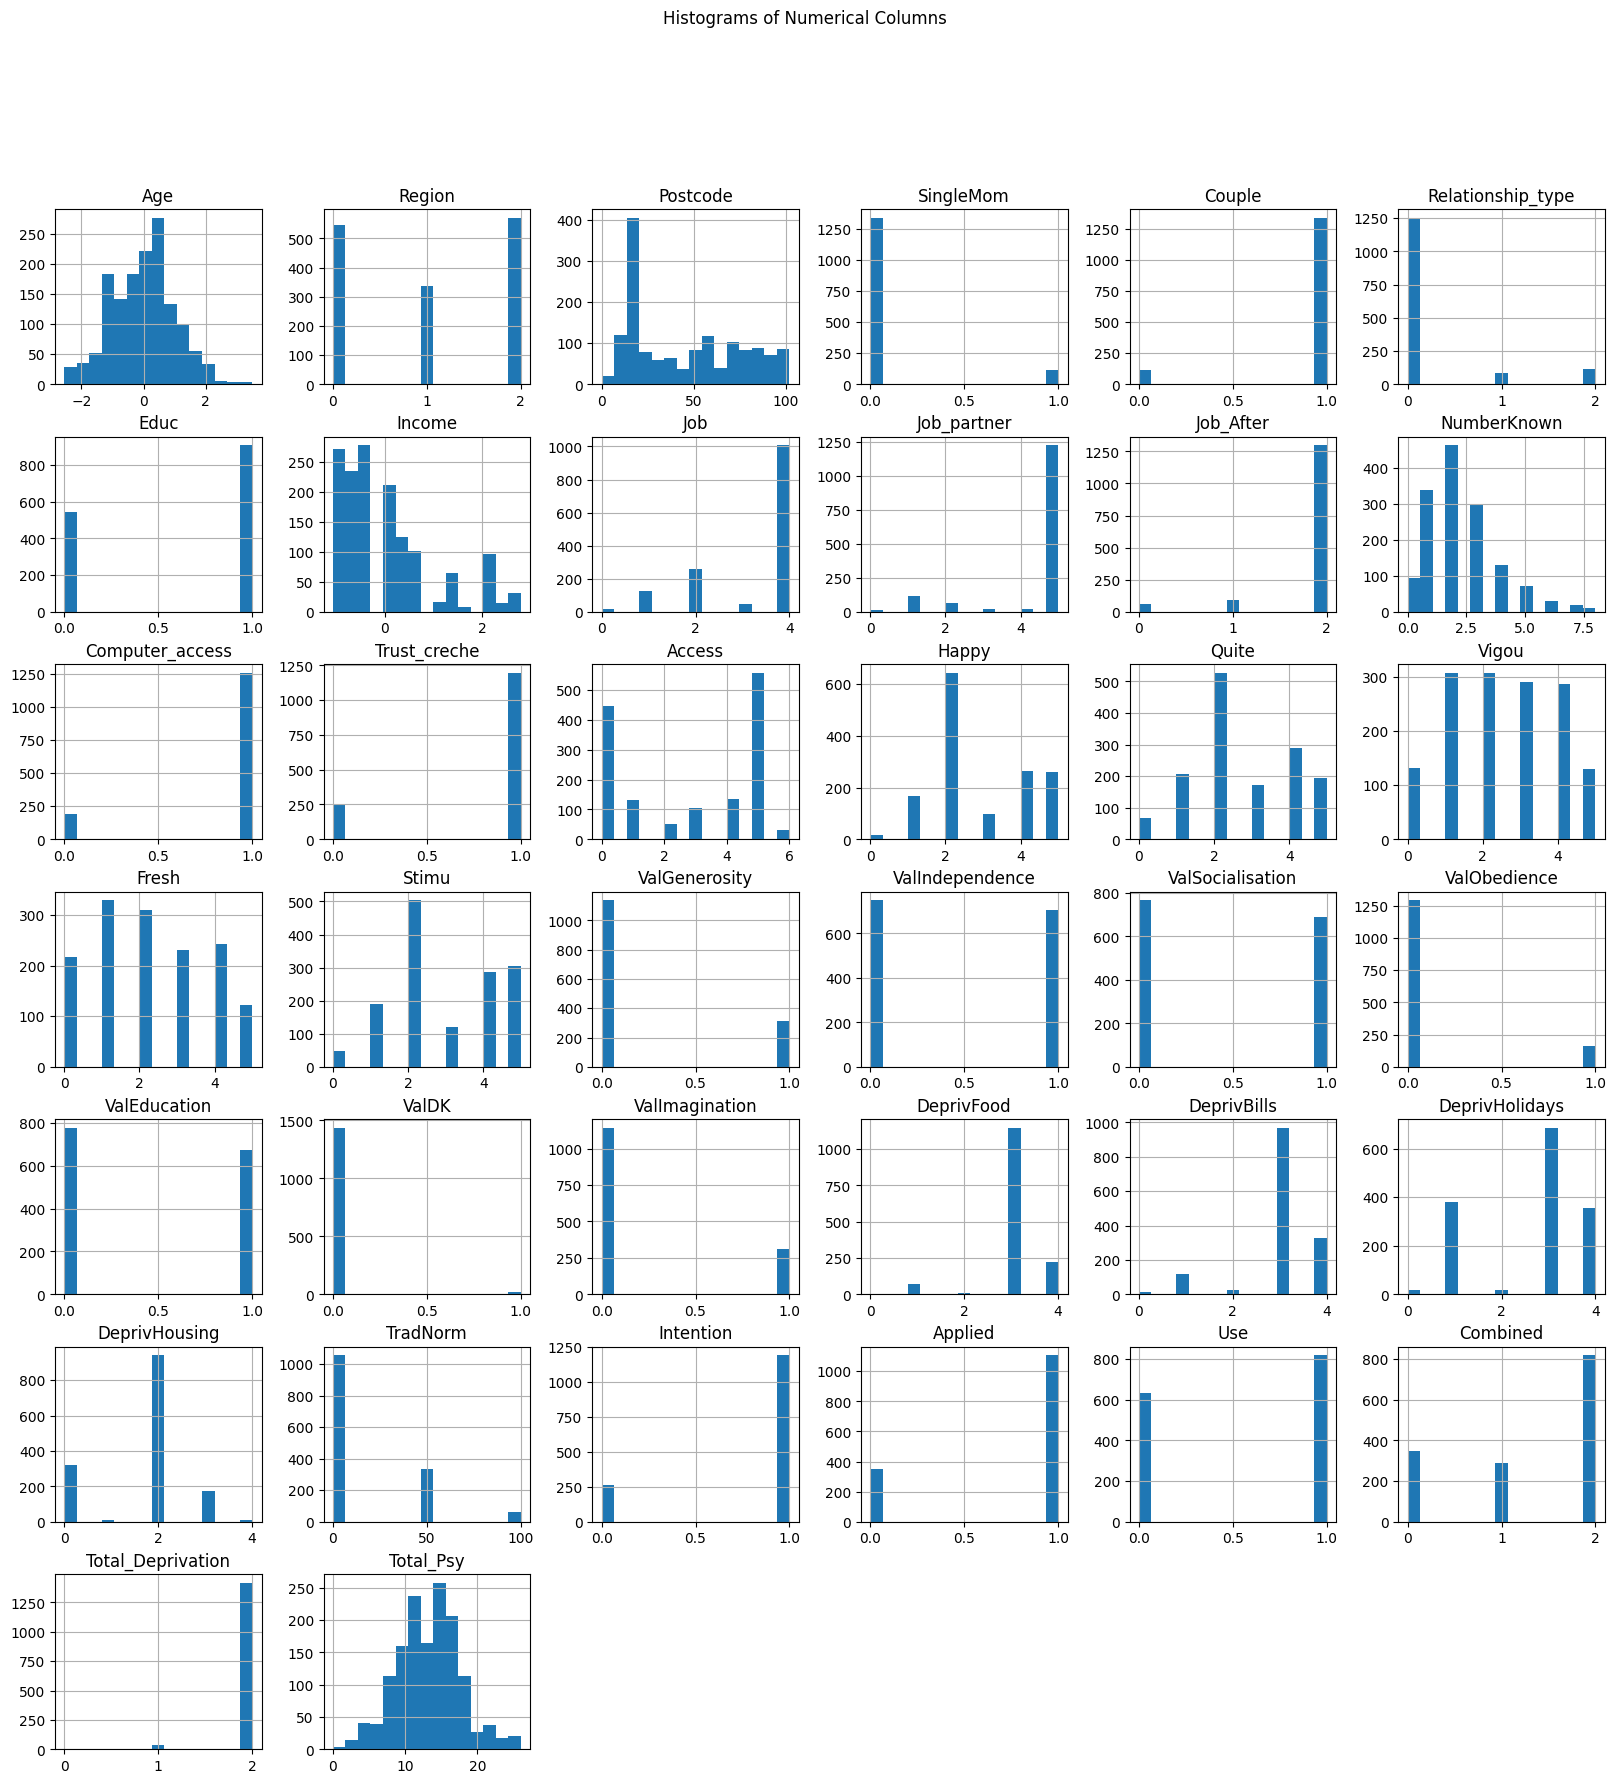

In [22]:
# Plot histograms for numerical columns
df[numerical_columns].hist(figsize=(20, 20), bins=15)
plt.suptitle('Histograms of Numerical Columns')
plt.show()

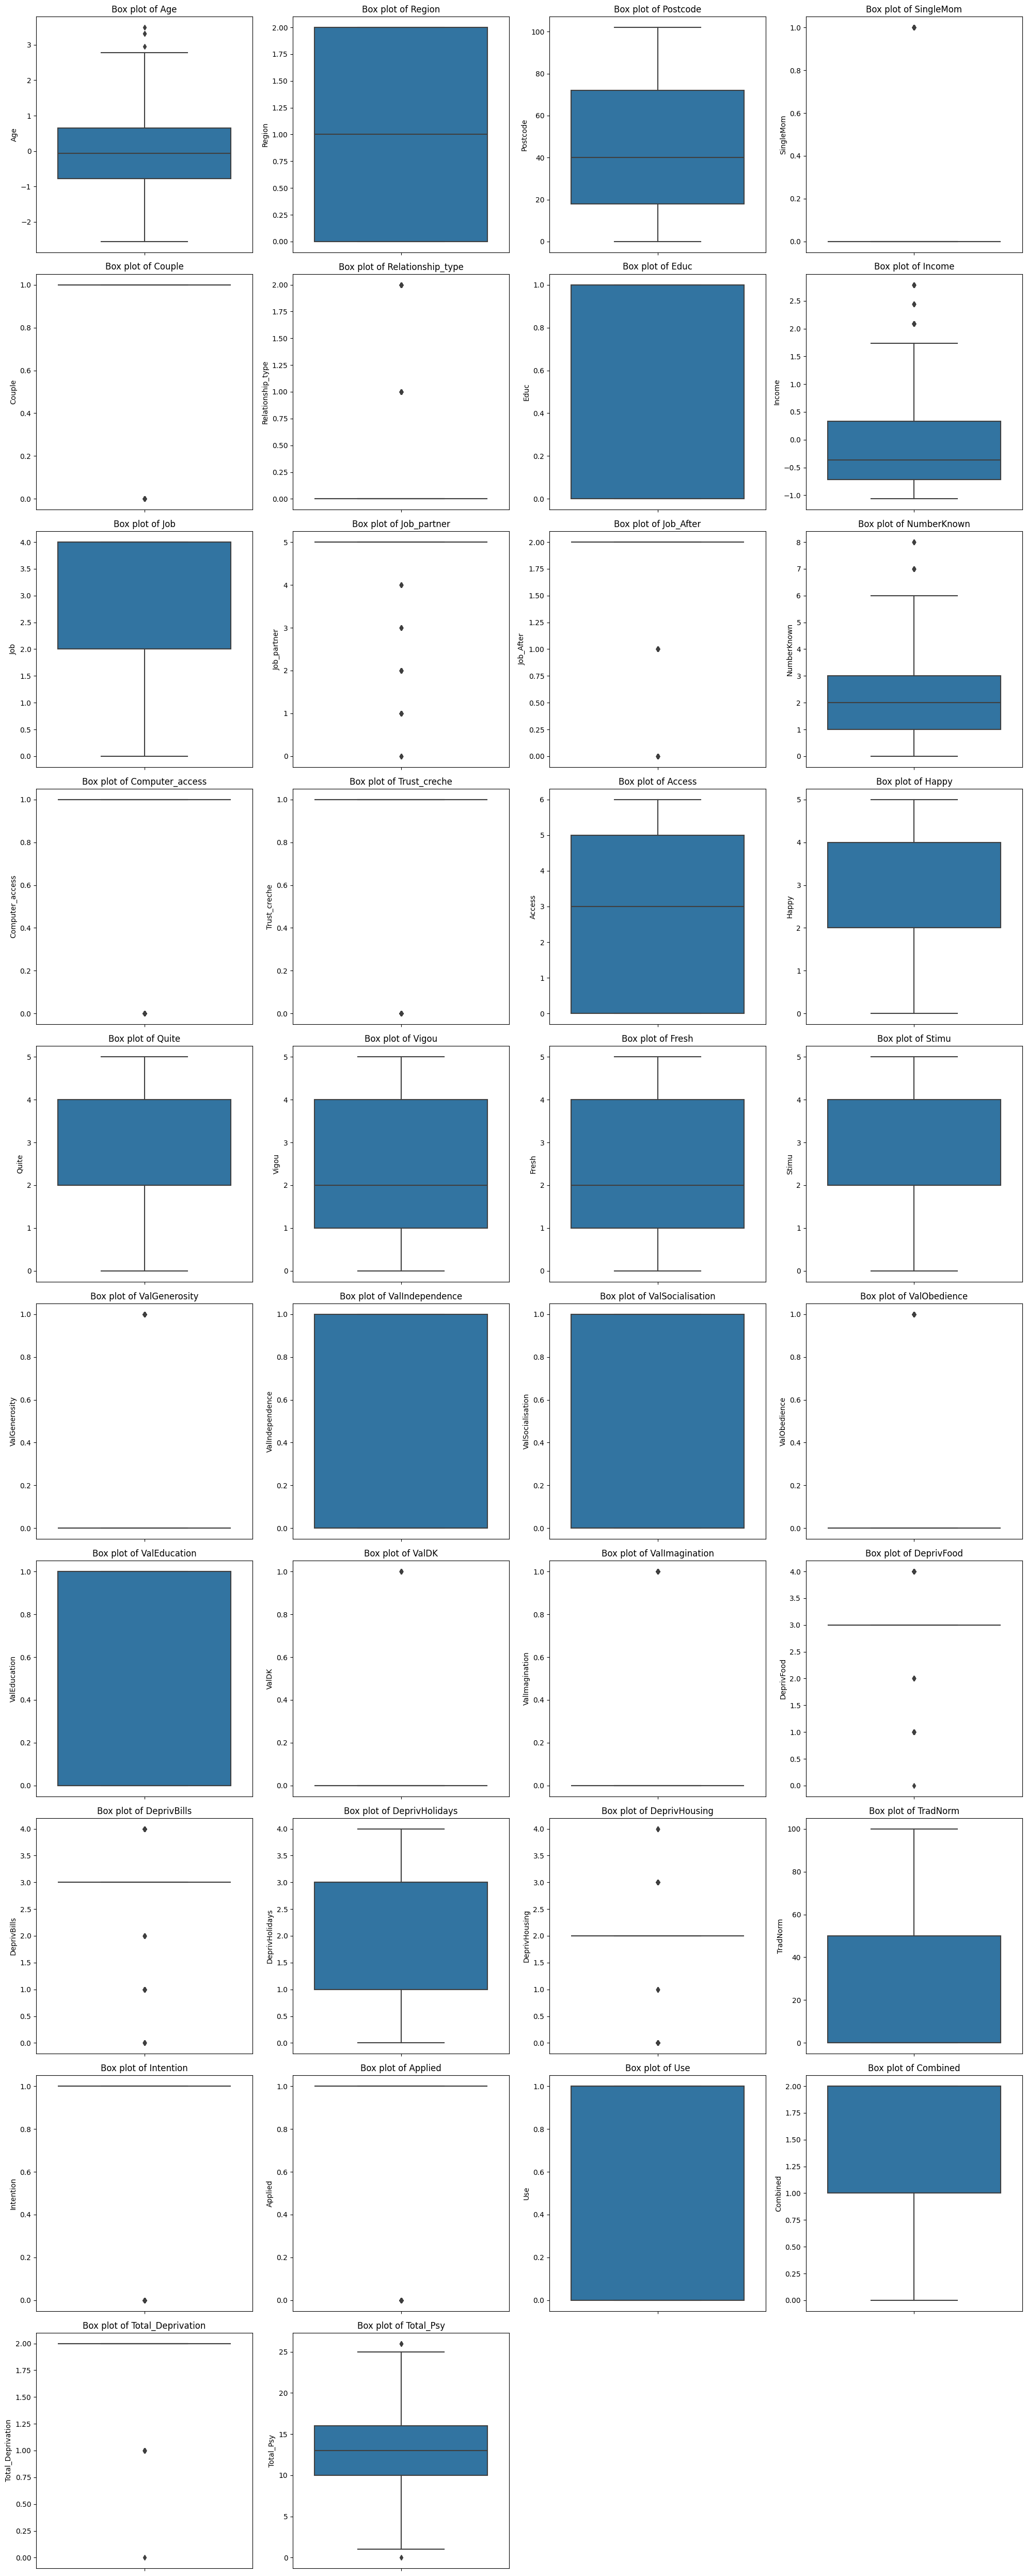

In [23]:
num_cols = len(numerical_columns)
num_rows = (num_cols + 3) // 4  # This will create enough rows to accommodate all columns

# Visualize box plots to check for outliers
plt.figure(figsize=(20, num_rows * 5))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.boxplot(data=df, y=column)
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

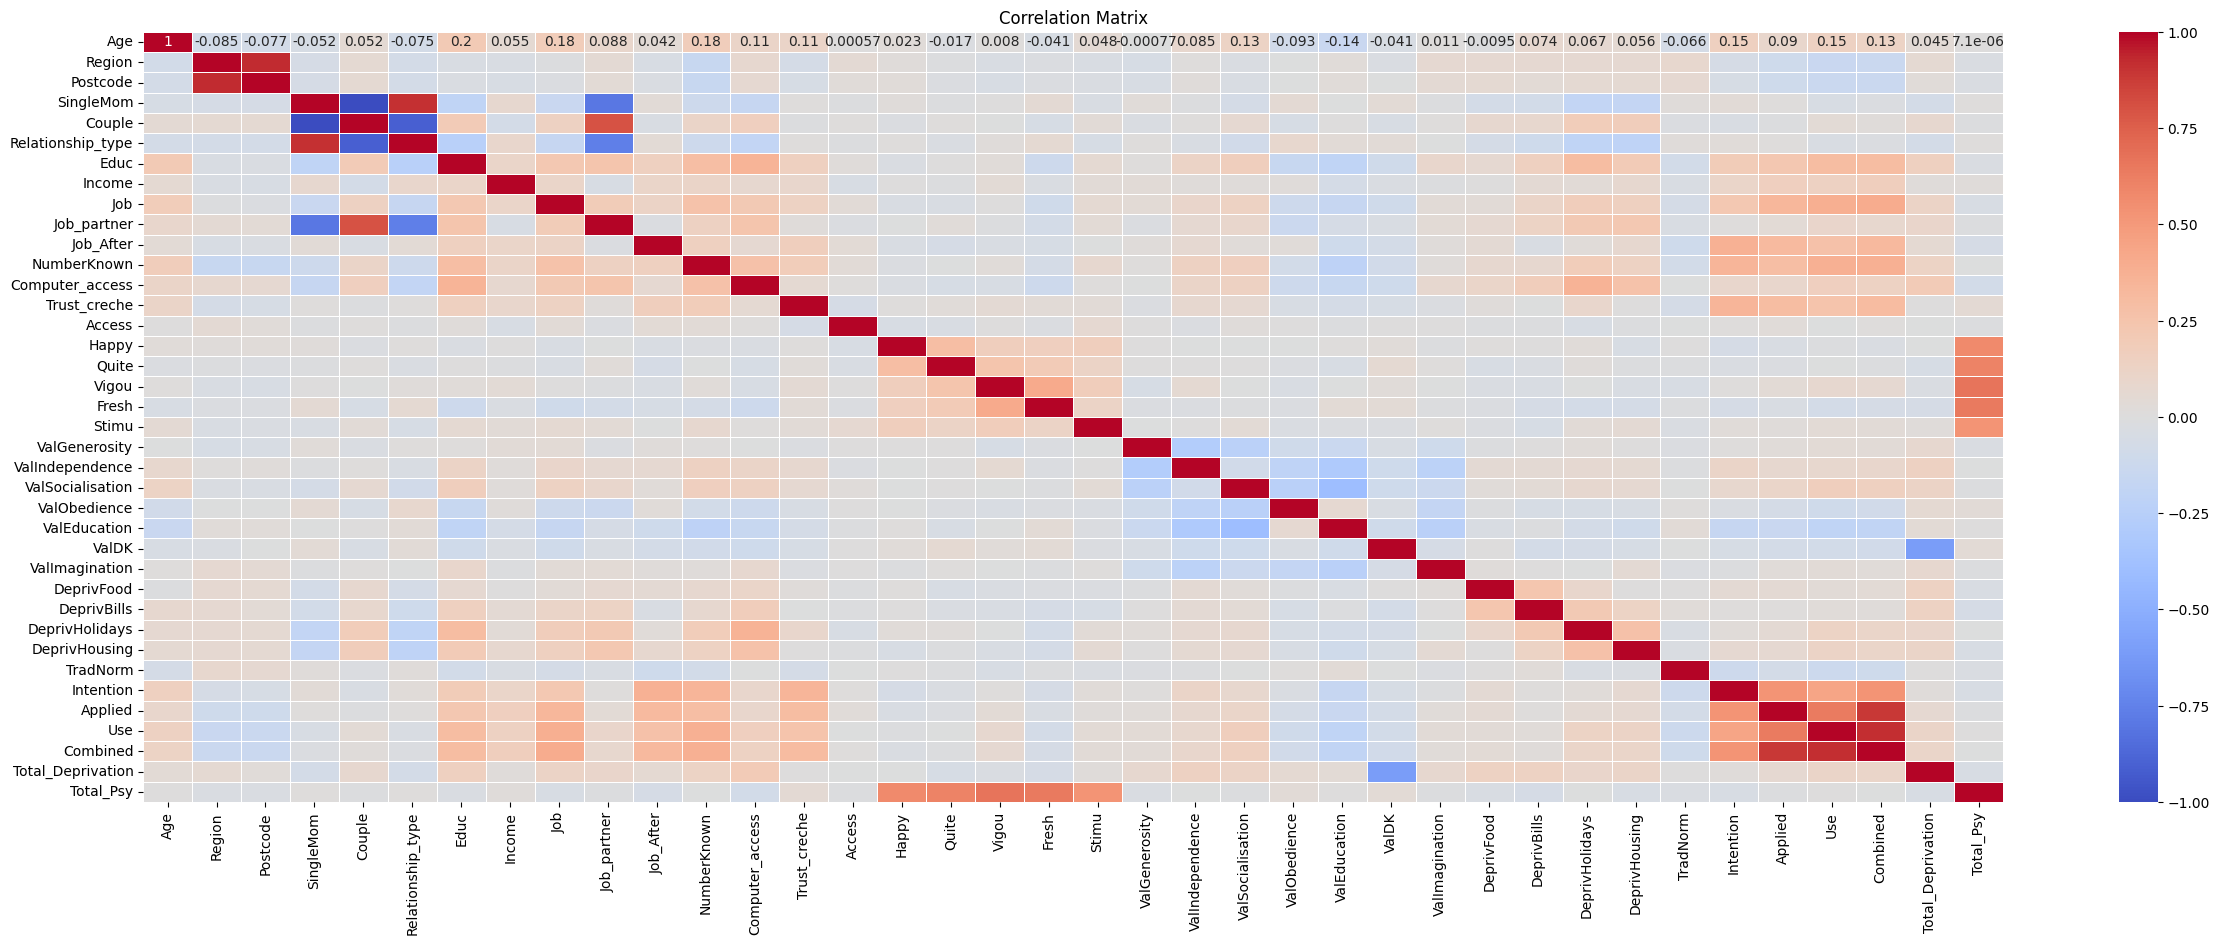

In [24]:
# Visualize correlation matrix
plt.figure(figsize=(30, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## **Feature Selection**: 


In [25]:
# Set thresholds for strong positive and negative correlations
positive_threshold = 0.15
negative_threshold = -0.15

# Find features with strong positive and negative correlation with the target variable
target_correlations = correlation_matrix['Intention']
strong_positive_correlations = target_correlations[target_correlations > positive_threshold]
strong_negative_correlations = target_correlations[target_correlations < negative_threshold]

print("Strong Positive Correlations:\n", strong_positive_correlations)
print("Strong Negative Correlations:\n", strong_negative_correlations)


Strong Positive Correlations:
 Age             0.150056
Educ            0.189255
Job             0.225074
Job_After       0.369547
NumberKnown     0.349656
Trust_creche    0.344437
Intention       1.000000
Applied         0.523757
Use             0.443746
Combined        0.531023
Name: Intention, dtype: float64
Strong Negative Correlations:
 ValEducation   -0.160461
Name: Intention, dtype: float64


Feature selection for Use and Applied

In [26]:
# Set thresholds for strong positive and negative correlations
positive_threshold = 0.15
negative_threshold = -0.15

# Find features with strong positive and negative correlation with the target variable
target_correlations = correlation_matrix['Combined']
strong_positive_correlations = target_correlations[target_correlations > positive_threshold]
strong_negative_correlations = target_correlations[target_correlations < negative_threshold]

print("Strong Positive Correlations:\n", strong_positive_correlations)
print("Strong Negative Correlations:\n", strong_negative_correlations)


Strong Positive Correlations:
 Educ                0.297636
Income              0.167620
Job                 0.404149
Job_After           0.322676
NumberKnown         0.375596
Trust_creche        0.307219
ValSocialisation    0.154631
Intention           0.531023
Applied             0.889115
Use                 0.919251
Combined            1.000000
Name: Combined, dtype: float64
Strong Negative Correlations:
 ValEducation   -0.190233
Name: Combined, dtype: float64


In [27]:
# Extract the features that have strong correlation with the target
strong_features = strong_positive_correlations.index.tolist()
feature_corr_matrix = df[strong_features].corr().abs()

# Set a threshold for high multicollinearity
multicollinearity_threshold = 0.5

# Find pairs of features with high multicollinearity
high_multicollinearity = [(i, j) for i in feature_corr_matrix.columns for j in feature_corr_matrix.columns if i != j and feature_corr_matrix.loc[i, j] > multicollinearity_threshold]

print(high_multicollinearity)


[('Intention', 'Applied'), ('Intention', 'Combined'), ('Applied', 'Intention'), ('Applied', 'Use'), ('Applied', 'Combined'), ('Use', 'Applied'), ('Use', 'Combined'), ('Combined', 'Intention'), ('Combined', 'Applied'), ('Combined', 'Use')]


# Train/test-split

In [38]:
# Prepare performance dataset to compare differents model before choose the best
data_question_1 = df.copy()
data_question_2_to_filter = df.copy()
data_question_2 = data_question_2_to_filter.drop(data_question_2_to_filter[data_question_2_to_filter.Intention == 0].index)

# Selecting the specified columns for df_select_q1
df_select_q1 = data_question_1[['Age', 'Educ', 'Job', 'Job_After', 'NumberKnown', 'Trust_creche', 'ValEducation', 'Intention']]
# Selecting the specified columns for df_select_q2
df_select_q2 = data_question_2[['Educ', 'Job', 'Job_After', 'NumberKnown', 'Computer_access', 'Trust_creche', 'ValSocialisation', 'Combined']]
performances = []


AttributeError: 'DataFrame' object has no attribute 'Intention'

In [ ]:
df_select_q2.isna().sum()

Educ                0
Job                 0
Job_After           0
NumberKnown         0
Computer_access     0
Trust_creche        0
ValSocialisation    0
Combined            0
dtype: int64

## Train/test-split Question 1

In [ ]:
# Create the X (differents predictor) and Y (intention) variables 
X = data_question_1.iloc[:,:32].values
y = data_question_1.iloc[:,32].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = data_question_1.iloc[:,:33].columns
    df.to_csv(f'../data/{name}.csv')

In [ ]:
# Create the X (differents predictor) and Y (intention) variables 
X = df_select_q1.iloc[:,:7].values
y = df_select_q1.iloc[:,7].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = df_select_q1.iloc[:,:8].columns
    df.to_csv(f'../data/{name}_features.csv')

## Train/test-split Question 2

In [ ]:
# Create the X (differents predictor) and Y (combined question 2) variables 
X = data_question_2.iloc[:,:32].values
y = data_question_2.iloc[:,35].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)
# Extract the original column names for the features
feature_columns = data_question_2.columns[:32].tolist()

# Add the target column name
columns = feature_columns + ['Combined']

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df_2 = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df_2.columns = columns
    df_2.to_csv(f'../data/{name}_question2.csv')

In [ ]:
# Create the X (differents predictor) and Y (combined question 2) variables 
X = df_select_q2.iloc[:,:7].values
y = df_select_q2.iloc[:,7].values

# Split into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# Split train set into training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

columns = [f'feature_{i}' for i in range(7)] + ['Combined']

# save the split into a file
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = df_select_q2.iloc[:,:8].columns
    df.to_csv(f'../data/{name}_question2_features.csv')

#  **Question 1**
- Data1: In summary, our dataset contains 1017 mothers, 32 features and 2 classes (Intention or not)
- Data1_select: In summary, our dataset contains 1017 mothers, 7 features and 2 classes (Intention or not)
- Question: Is it possible to predict which profile do not have intention ? And which variables is the most important to predict that ?

In [85]:
# Load dataset 
train = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train.csv', index_col=0)
val = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val.csv', index_col=0)
test = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test.csv', index_col=0)
performances = []

# Load dataset features selections
train_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_features.csv', index_col=0)
val_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_features.csv', index_col=0)
test_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_features.csv', index_col=0)
performances = []

In [40]:
## Feature selection

X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = val_features.iloc[:,:-1], val_features.iloc[:,-1]
X_test, y_test = test_features.iloc[:,:-1], test_features.iloc[:,-1]

fit_and_evaluate_models(X_train,y_train,subset_name="feature_select")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

In [41]:
## Demographic data

X_train, y_train = train.iloc[:,:-22], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-22], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-22], test.iloc[:,-1]

fit_and_evaluate_models(X_train,y_train,subset_name="demographic")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

In [42]:
## All data
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

fit_and_evaluate_models(X_train,y_train,subset_name="all")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

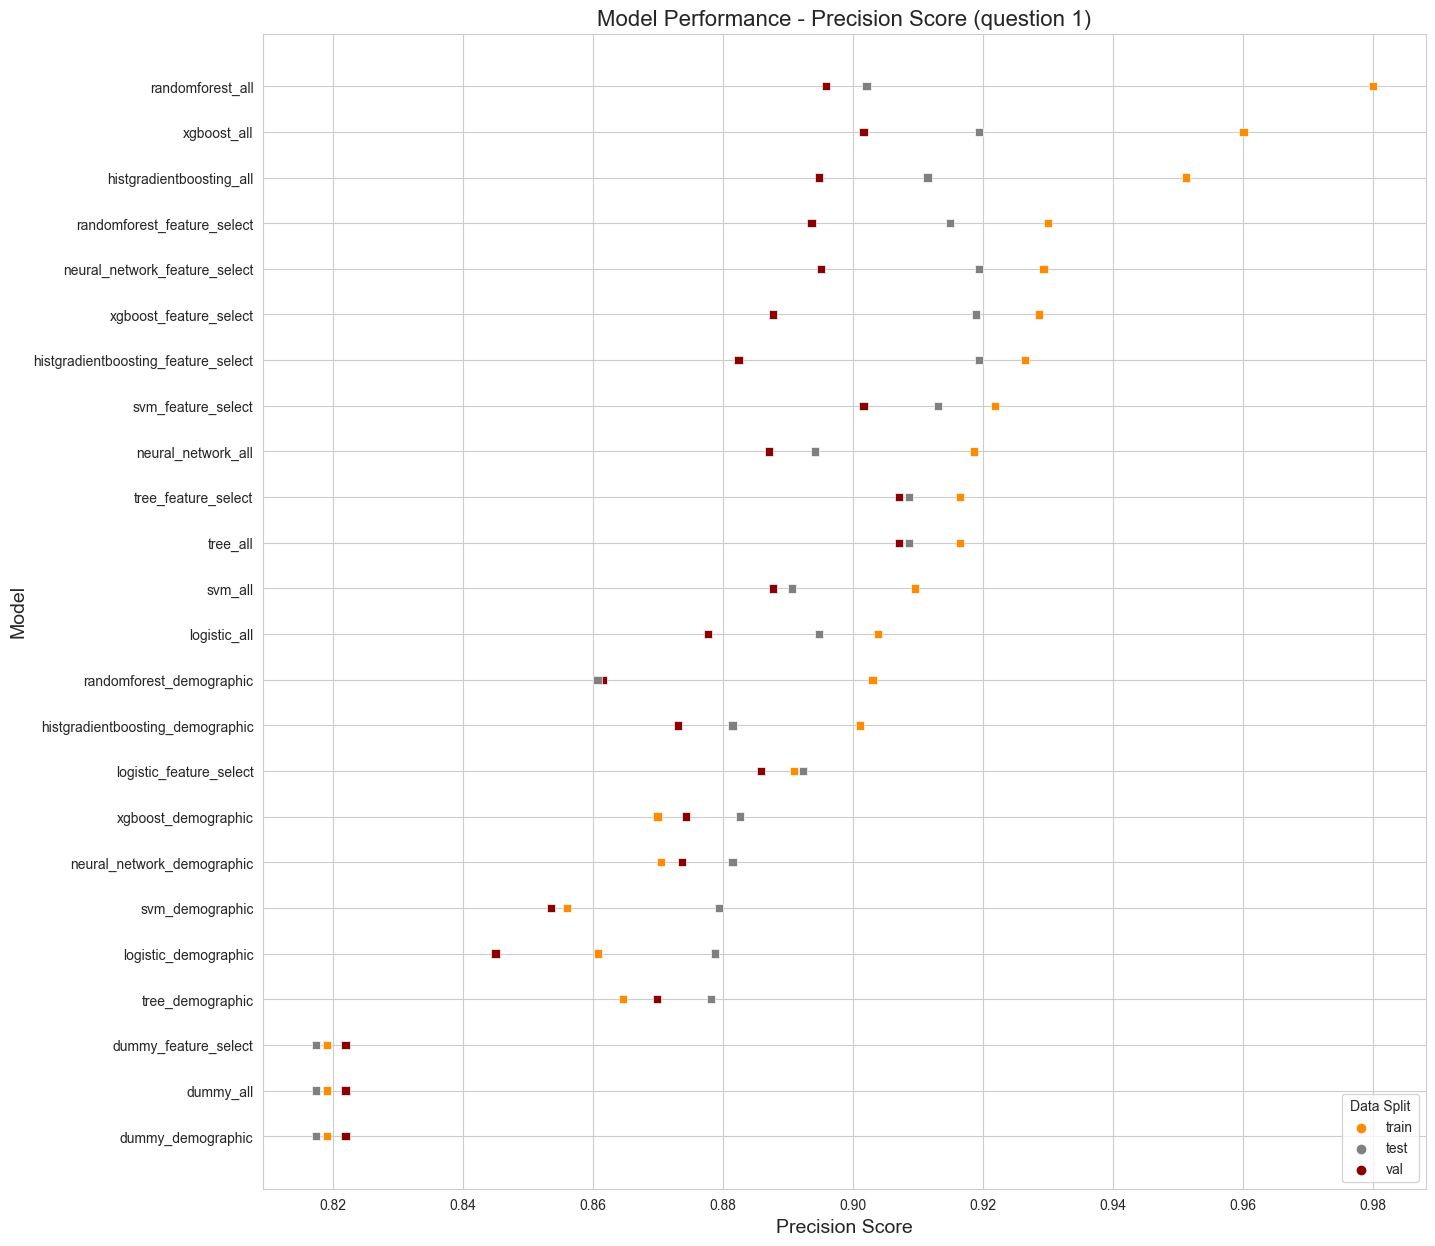

In [47]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(15, 15))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='precision', ascending=False), 
                        y='model', 
                        x='precision', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'grey', 'darkred'])

# Add plot title and labels
plt.title("Model Performance - Precision Score (question 1)", fontsize=16)
plt.xlabel("Precision Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Customize legend
plt.legend(title='Data Split', loc='lower right')
# Optionally save the plot to a file
plt.savefig('/Users/sylvainestebe/Code/data_child/plots/Q1_precision.png', dpi=300)

# Show the plot
plt.show()


## Model selected

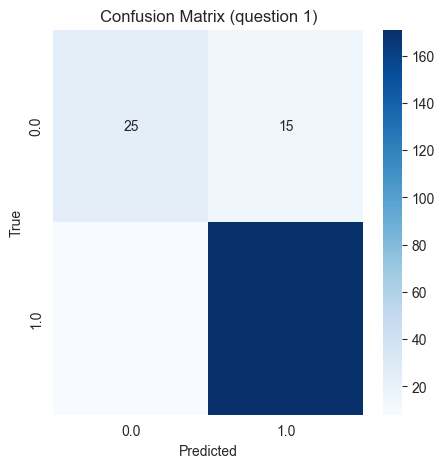

In [86]:
## All data
X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = val_features.iloc[:,:-1], val_features.iloc[:,-1]
X_test, y_test = test_features.iloc[:,:-1], test_features.iloc[:,-1]

# Load the best model
best_model = pkl.load(open('/Users/sylvainestebe/Code/data_child/models/Q1_histgradientboosting_feature_select.pkl', 'rb'))

# Predict on the validation set
best_preds = best_model.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, best_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True,  cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix (question 1)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/Users/sylvainestebe/Code/data_child/plots/Q1_confusion_matrice', dpi=300)

plt.show()



In [87]:

# Print classification report
print("Question 1"  + classification_report(y_test, best_preds))
best_model

Question 1              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68        40
         1.0       0.92      0.96      0.94       179

    accuracy                           0.89       219
   macro avg       0.84      0.79      0.81       219
weighted avg       0.89      0.89      0.89       219



GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'l2_regularization': [0, 0.1, 1, 10],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9], 'max_iter': [100, 200, 300]},
             scoring='precision')

In [50]:
best_model.best_estimator_

HistGradientBoostingClassifier(l2_regularization=10, learning_rate=0.2,
                               max_depth=3, max_iter=200, random_state=42)

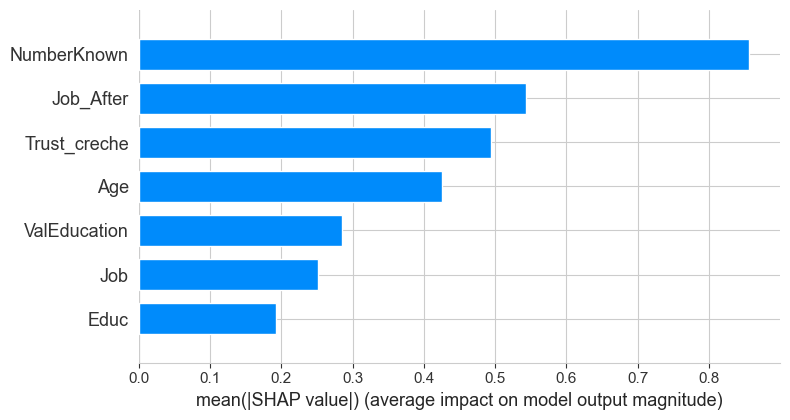

In [51]:
import shap
import matplotlib.pyplot as plt

# Create an explainer object
explainer = shap.Explainer(best_model.best_estimator_, X_train)
shap_values = explainer(X_train)

# Create the SHAP summary plot and save it
plt.figure(figsize=(3, 3))
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar', show=False)
plt.savefig("/Users/sylvainestebe/Code/data_child/plots/Q1_features_importance.png", dpi=700)
plt.show()


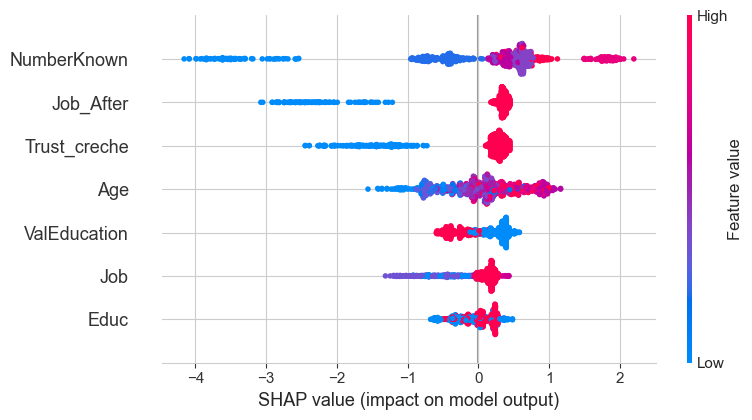

In [52]:
# Create the SHAP summary plot and save it
plt.figure(figsize=(3, 3))
shap.summary_plot(shap_values, X_train,max_display=10,show=False)
plt.savefig("/Users/sylvainestebe/Code/data_child/plots/Q1_shap.png", dpi=700)
plt.show()


# Question 2

Data1: In summary, our dataset contains 1017 mothers, 32 features and 2 classes (Intention or not)
Data1_select: In summary, our dataset contains 1017 mothers, 7 features and 2 classes (Intention or not)


In [53]:
# Load dataset 
train = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_question2.csv', index_col=0)
val = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_question2.csv', index_col=0)
test = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_question2.csv', index_col=0)
performances = []


# Load dataset features selections
train_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/train_question2_features.csv', index_col=0)
val_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/val_question2_features.csv', index_col=0)
test_features = pd.read_csv(f'/Users/sylvainestebe/Code/data_child/data/test_question2_features.csv', index_col=0)
performances = []

In [54]:
## Features selections
X_train, y_train = train_features.iloc[:,:-1], train_features.iloc[:,-1]
X_val, y_val = val_features.iloc[:,:-1], val_features.iloc[:,-1]
X_test, y_test = test_features.iloc[:,:-1], test_features.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="features selections")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

In [55]:
## DEMOGRAPHIC
X_train, y_train = train.iloc[:,:-22], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-22], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-22], test.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="demographic")

/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

In [56]:

## All data
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

fit_and_evaluate_models_2(X_train,y_train,subset_name="all")


/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sylvainestebe/Code/data_child/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

### Performance

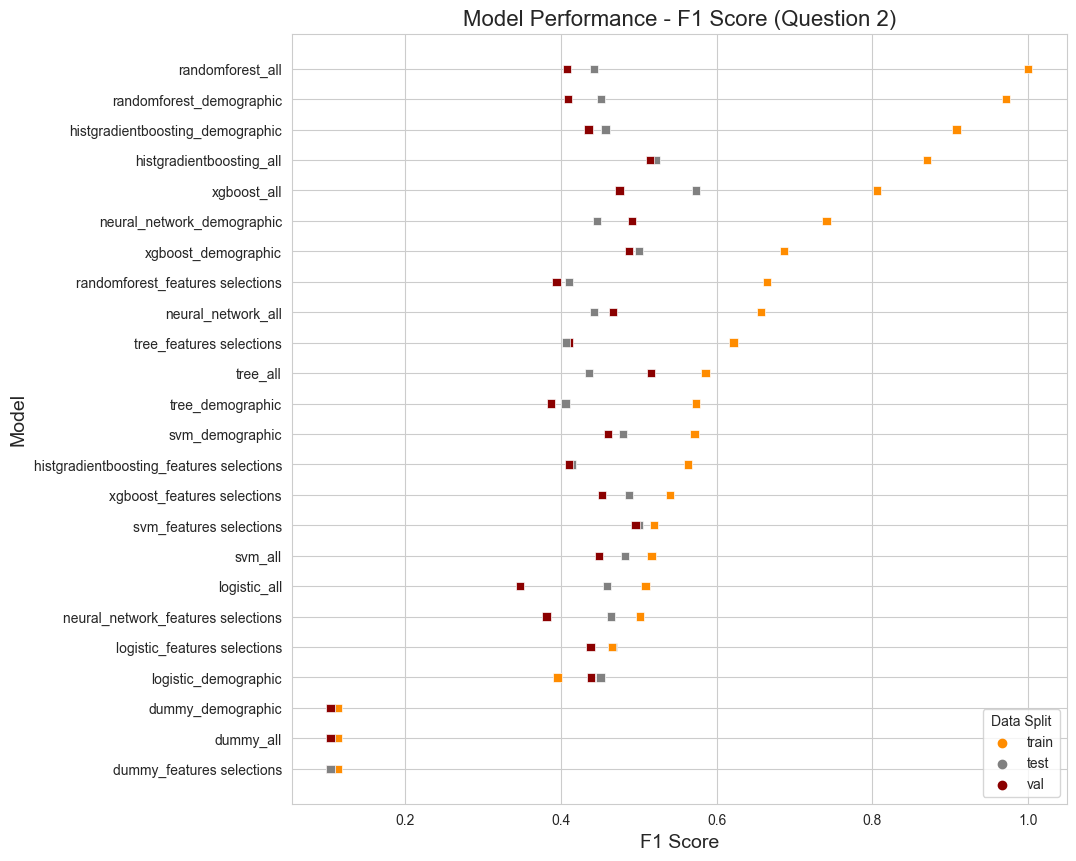

In [57]:
perf_df = pd.DataFrame(performances)
# Set seaborn style
sns.set_style('whitegrid')
# Create a figure for the plot
plt.figure(figsize=(10, 10))
# Create the scatter plot
sns.scatterplot(data=perf_df.sort_values(by='f1', ascending=False), 
                        y='model', 
                        x='f1', 
                        marker='s', 
                        hue='split', 
                        palette=['darkorange', 'grey', 'darkred'])

# Add plot title and labels
plt.title("Model Performance - F1 Score (Question 2)", fontsize=16)
plt.xlabel("F1 Score", fontsize=14)
plt.ylabel("Model", fontsize=14)
# Automatically adjust x-axis limits based on data
plt.xlim(perf_df['f1'].min() - 0.05, perf_df['f1'].max() + 0.05)
# Customize legend
plt.legend(title='Data Split', loc='lower right')
# Optionally save the plot to a file
plt.savefig('/Users/sylvainestebe/Code/data_child/plots/Q2_model_performance_f1.png', dpi=300)

# Show the plot
plt.show()


## Select the best model

### Feature selection and all

In [58]:

## Features selections
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

# Load the best model
best_model = pkl.load(open('/Users/sylvainestebe/Code/data_child/models/Q2_xgboost_all.pkl', 'rb'))


In [59]:
best_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

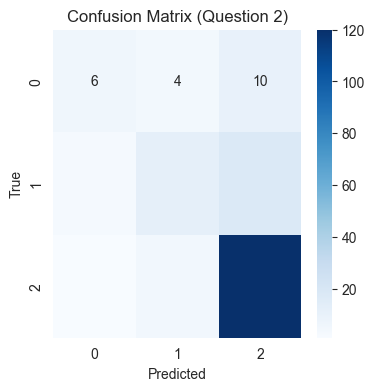

In [60]:
# Predict on the validation set
best_preds = best_model.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, best_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Question 2)')
plt.savefig('/Users/sylvainestebe/Code/data_child/plots/Q2_confusion.png', dpi=300)

plt.show()


In [83]:

# Print classification report
print("Question 2"  + classification_report(y_test, best_preds))
best_model

Question 2              precision    recall  f1-score   support

         0.0       0.60      0.30      0.40        20
         1.0       0.57      0.36      0.44        33
         2.0       0.81      0.95      0.88       126

    accuracy                           0.77       179
   macro avg       0.66      0.54      0.57       179
weighted avg       0.74      0.77      0.74       179



RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [10, 50, 100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 10, 100],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='f1_macro')

In [63]:
import shap
import matplotlib.pyplot as plt

# Create an explainer object
explainer = shap.Explainer(best_model.best_estimator_, X_train)
shap_values_cat = explainer(X_train)

# Create the SHAP summary plot and save it
plt.figure(figsize=(3, 3))
shap.summary_plot(shap_values_cat[0,:,0], features=X_train, feature_names=X_train.columns, plot_type='bar', show=False)
plt.savefig("/Users/sylvainestebe/Code/data_child/plots/Q1_features_importance.png", dpi=700)
plt.show()


AssertionError: Summary plots need a matrix of shap_values, not a vector.

<Figure size 300x300 with 0 Axes>

Summary plot for class 0


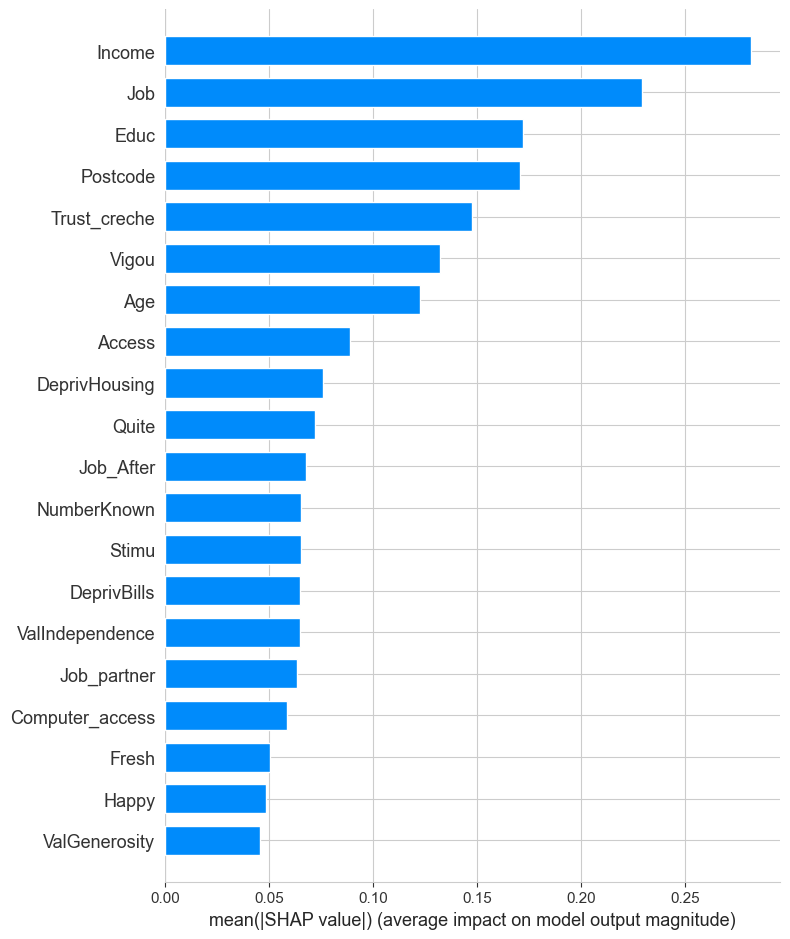

Summary plot for class 1


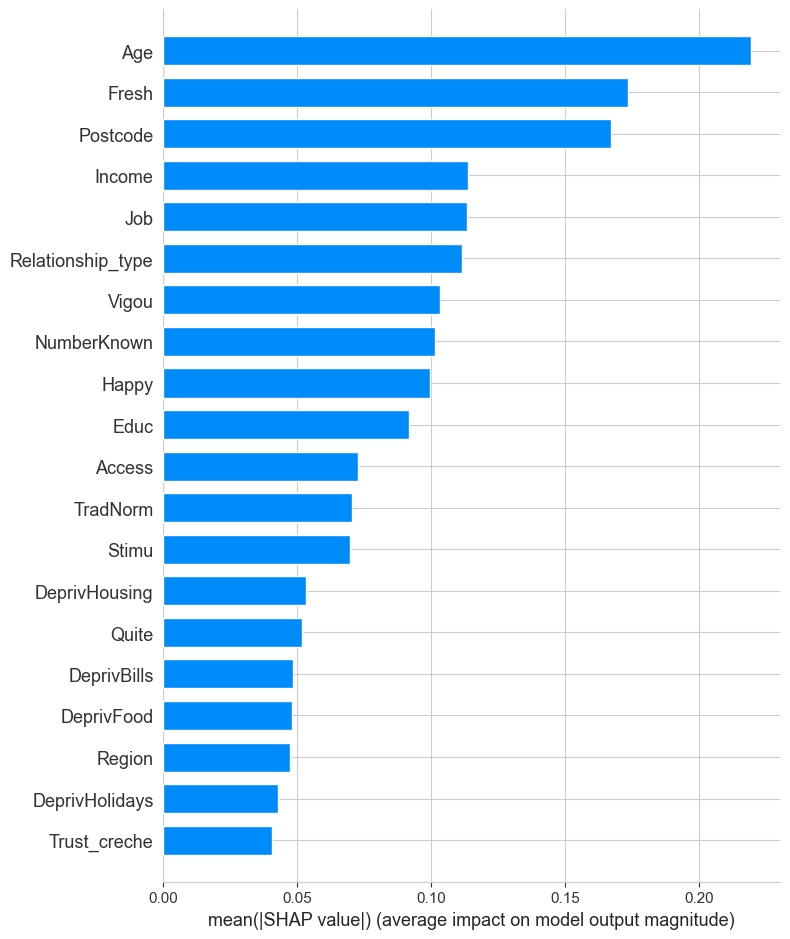

Summary plot for class 2


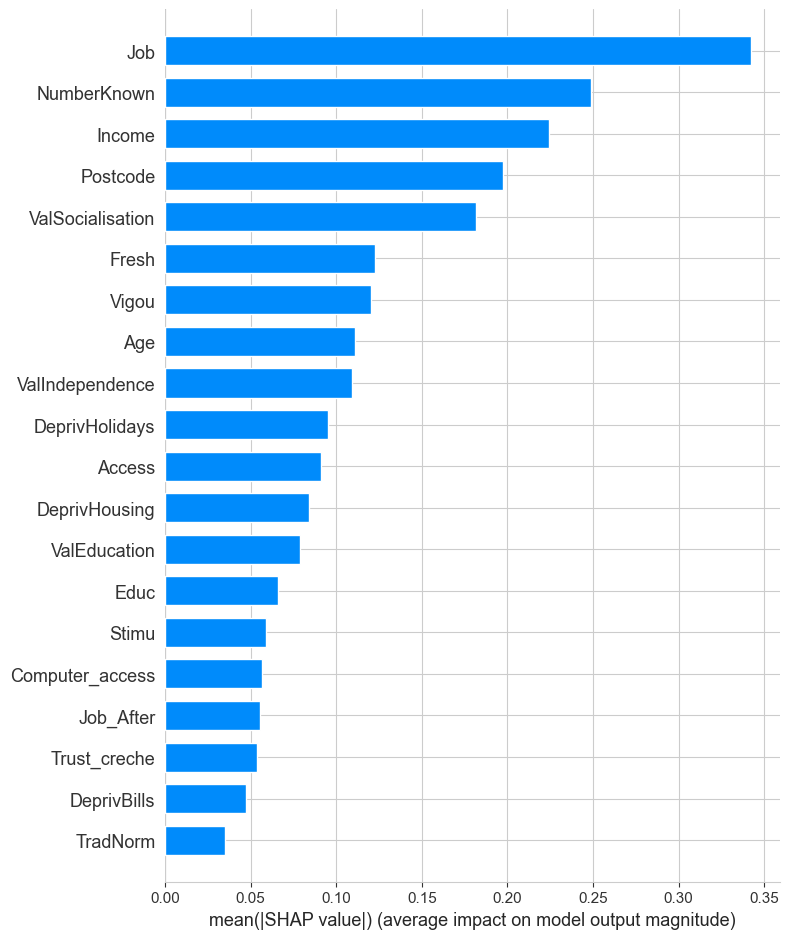

Waterfall plot for the first instance in class 0


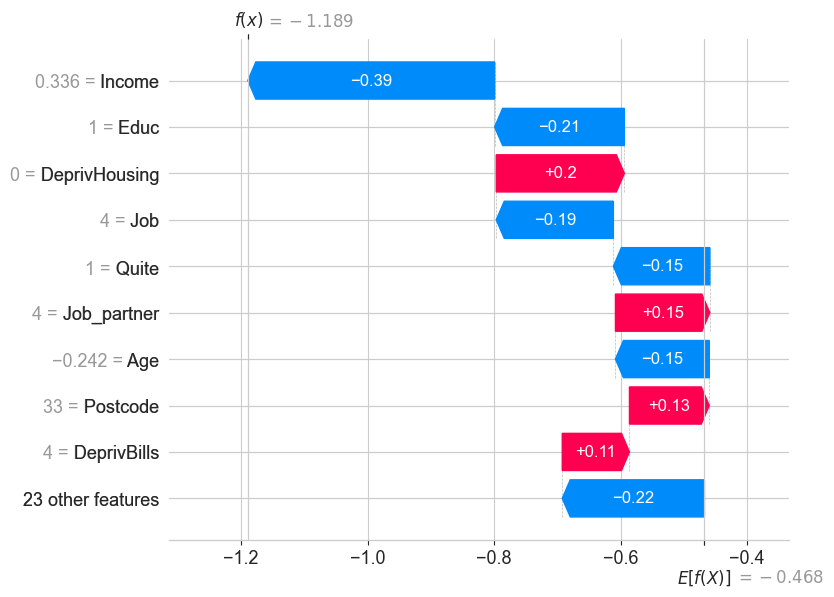

Waterfall plot for the first instance in class 1


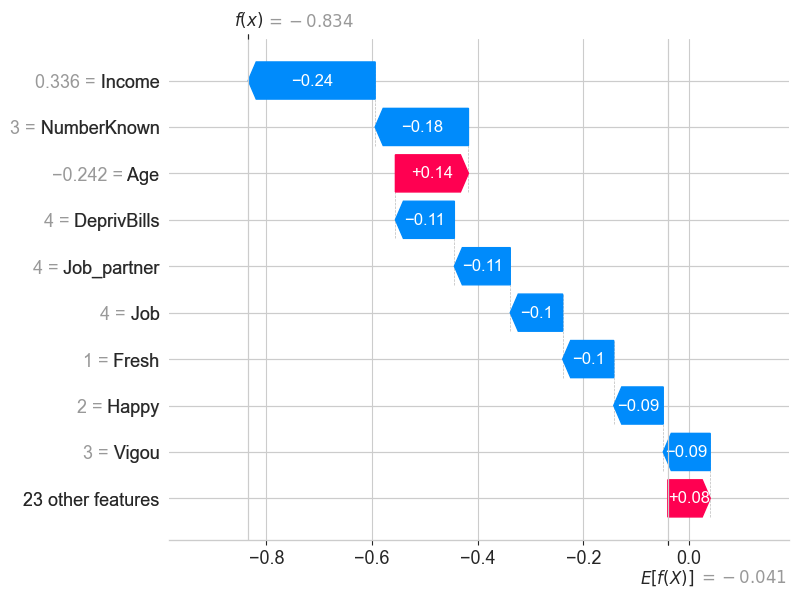

Waterfall plot for the first instance in class 2


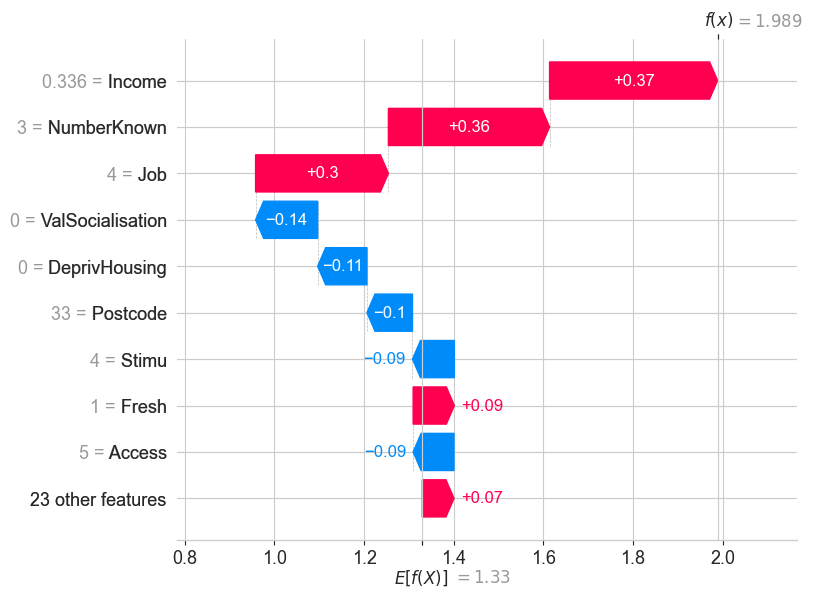

In [67]:
import shap

# Create an explainer object using the best estimator
explainer = shap.Explainer(best_model.best_estimator_, X_train)

# Calculate SHAP values for the training set
shap_values = explainer(X_train)


# Summary plot for each class
for class_idx in range(shap_values.values.shape[2]):
    plt.figure(figsize=(3, 3))
    print(f"Summary plot for class {class_idx}")
    shap.summary_plot(shap_values[:, :, class_idx], X_train,plot_type='bar',show=False)
    plt.savefig(f"/Users/sylvainestebe/Code/data_child/plots/Q2_{class_idx}features_importance.png", dpi=700)
    plt.show()

# Waterfall plot for the first instance in the training set for each class
for class_idx in range(shap_values.values.shape[2]):
    print(f"Waterfall plot for the first instance in class {class_idx}")
    shap.plots.waterfall(shap_values[0, :, class_idx])
